# Classification Model

This notebook details training a classification model to determine if an image has a container ship in it or not. The model will be made using a pretrained resnext50 model that will then be fine-tuned to binary classification. The model is trained using progressive resizingof input images.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
PATH = Path('F:/ships')

In [5]:
seg_df = pd.read_csv(PATH/'train_ship_segmentations_v2.csv')

In [6]:
seg_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [7]:
seg_df.shape

(231723, 2)

In [8]:
seg_df['ships'] = seg_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

In [9]:
unique_img_ids = seg_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1 if x>0 else 0)

In [10]:
unique_img_ids.head()

,ImageId,ships,has_ship
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,1,1
3,000194a2d.jpg,5,1
4,0001b1832.jpg,0,0


In [11]:
classifier_df = unique_img_ids.copy()

In [12]:
classifier_df.drop(['ships'], axis=1, inplace=True)

In [13]:
classifier_df.head()

,ImageId,has_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,0001b1832.jpg,0


In [14]:
# Corrupted images
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] 

In [15]:
classifier_df = classifier_df[~classifier_df.ImageId.isin(exclude_list)]
classifier_df.reset_index(inplace=True, drop=True)

In [16]:
classifier_df.head()

,ImageId,has_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,0001b1832.jpg,0


In [17]:
classifier_df.to_csv(PATH/'ships_classification.csv')

In [18]:
n = len(classifier_df)
n

192555

In [19]:
val_idxs = get_cv_idxs(n)

In [20]:
f = resnext50
sz = 256

In [21]:
aug_tfms = [RandomRotate(5), 
            RandomLighting(0.05, 0.05), 
            RandomFlip(),
            RandomDihedral()
            ]


tfms = tfms_from_model(f, sz, aug_tfms=aug_tfms, max_zoom=1.01)

In [22]:
f_names = classifier_df.ImageId.values

In [24]:
TRAIN_DN = 'train_v2'

In [25]:
x_names = np.array([Path(TRAIN_DN)/o for o in f_names])

In [26]:
y_vals = classifier_df.has_ship.values

In [27]:
bs = 32

md = ImageClassifierData.from_names_and_array(PATH, x_names, y_vals, [0, 1], val_idxs=val_idxs, bs=bs, tfms=tfms)

In [28]:
denorm = md.trn_ds.denorm

In [29]:
md = md.resize(sz, 'tmp')

In [30]:
x, y = next(iter(md.trn_dl))

In [31]:
x.shape, y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [33]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

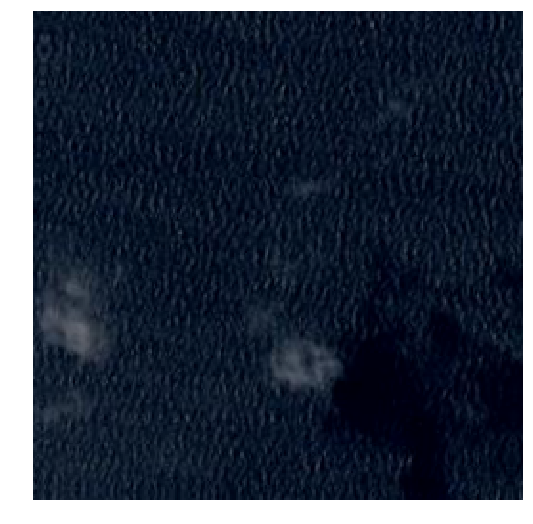

In [34]:
show_img(denorm(x[2])[0], figsize = (9,9))

# 256x256 Training

In [35]:
learn = ConvLearner.pretrained(f, md, ps=0.4)
learn.opt_fn=optim.Adam

In [36]:
learn.model.cuda();

 69%|█████████████████████████████████████████████▏                    | 1257/1834 [09:38<04:25,  2.17it/s, loss=0.746]

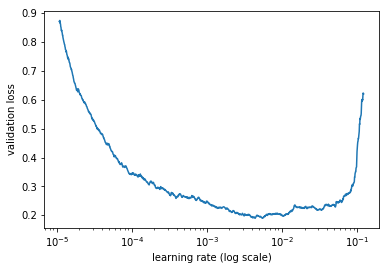

In [39]:
learn.lr_find()
learn.sched.plot()

In [41]:
lr=3e-3
wd=1e-7

lrs = np.array([lr/50,lr/10,lr])

In the first training stage, only the new linear layers added for classification are trained. Then the encoder of the model is unfrozen and the entire model is trained. 98.7% accuracy is achieved on 256x256 images.

In [41]:
learn.fit(lr,1,wds=wd,cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.168751   0.137895   0.948067  
    1      0.148482   0.129955   0.950949                                                                              
    2      0.134848   0.124162   0.95217                                                                               
    3      0.12662    0.115989   0.956116                                                                              
    4      0.131543   0.111626   0.95796                                                                               


[0.11162609212948468, 0.9579600794177714]

In [42]:
learn.save('256_classifier_rx50_1')

In [37]:
learn.load('256_classifier_rx50_1')

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [43]:
learn.model.cuda();

In [44]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.103494   0.11723    0.956869  
    1      0.080521   0.078163   0.970476                                                                              
    2      0.071558   0.067274   0.976033                                                                              
    3      0.068116   0.05577    0.980006                                                                              
    4      0.058869   0.051326   0.982447                                                                              
    5      0.046708   0.047924   0.983537                                                                              
    6      0.039637   0.043561   0.984732                                                                              
    7      0.040131   0.040517   0.985692                                                                           

[0.036718131431878125, 0.9872763625976994]

In [45]:
learn.save('256_classifier_rx50_2')

# 512x512 Training

In [46]:
sz = 512
bs = 16

In [47]:
md = ImageClassifierData.from_names_and_array(PATH, x_names, y_vals, [0, 1], val_idxs=val_idxs, bs=bs, tfms=tfms)
denorm = md.trn_ds.denorm

In [48]:
md = md.resize(512, 'tmp')

In [49]:
from shutil import copy2

In [50]:
copy2(PATH/'tmp/256/models/256_classifier_rx50_2.h5', PATH/'tmp/512/models/')

'F:\\ships\\tmp\\512\\models\\256_classifier_rx50_2.h5'

In [51]:
learn = ConvLearner.pretrained(f, md, ps=0.4)
learn.opt_fn=optim.Adam

In [52]:
learn.model.cuda();

In [53]:
learn.load('256_classifier_rx50_2')

 53%|██████████████████████████████████▍                              | 5106/9628 [09:02<08:00,  9.42it/s, loss=0.0845]

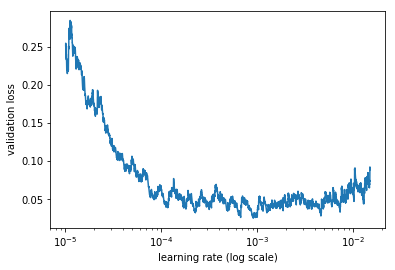

In [54]:
learn.lr_find()
learn.sched.plot()

In [55]:
lr=lr/10
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

Training on 512x512 images increases accuracy to 98.9%

In [56]:
learn.fit(lr,1,wds=wd,cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.032121   0.056591   0.985043  
    1      0.033749   0.041705   0.986627                                                                              
    2      0.036132   0.055623   0.986082                                                                              
    3      0.042418   0.047132   0.986939                                                                              


[0.04713248558692051, 0.9869387967074342]

In [57]:
learn.save('512_classifier_rn50_1')

In [58]:
learn.unfreeze()
learn.bn_freeze(True)

In [59]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=6, use_clr=(20,6))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.030346   0.035468   0.988523  
    1      0.030382   0.035928   0.987718                                                                              
    2      0.024795   0.034471   0.988834                                                                              
    3      0.021431   0.034103   0.989354                                                                              
    4      0.015764   0.03701    0.989432                                                                              
    5      0.019252   0.036717   0.989613                                                                              


[0.03671666763150406, 0.9896133572226117]

In [60]:
learn.save('512_classifier_rn50_2')

# 768x768 Training

In [61]:
sz = 768
bs = 8

In [62]:
md = ImageClassifierData.from_names_and_array(PATH, x_names, y_vals, [0, 1], val_idxs=val_idxs, bs=bs, tfms=tfms)
denorm = md.trn_ds.denorm

In [63]:
copy2(PATH/f'tmp/512/models/512_classifier_rn50_2.h5', PATH/f'models/')

'F:\\ships\\models\\512_classifier_rn50_2.h5'

In [64]:
learn = ConvLearner.pretrained(f, md, ps=0.5)
learn.opt_fn=optim.Adam

In [65]:
learn.model.cuda();

In [66]:
learn.load('512_classifier_rn50_2')

 16%|██████████▏                                                     | 3051/19256 [07:33<40:09,  6.73it/s, loss=0.0545]

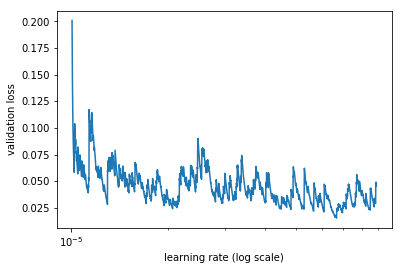

In [67]:
learn.lr_find()
learn.sched.plot()

In [68]:
lr=lr/4
wd=1e-7

lrs = np.array([lr/50,lr/10,lr])

In [69]:
learn.fit(lr,1,wds=wd,cycle_len=2,use_clr=(20,4))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.021926   0.099629   0.988107  
    1      0.011567   0.081979   0.988185                                                                              


[0.08197938930608421, 0.9881851938407208]

In [70]:
learn.save('768_classifier_rn50_1')

In [71]:
learn.unfreeze()
learn.bn_freeze(True)

The final model achieves 98.99% accuracy

In [72]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=4, use_clr=(20,4))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.029413   0.040381   0.988705  
    1      0.012765   0.038352   0.98938                                                                               
    2      0.025354   0.039407   0.989899                                                                              
    3      0.00866    0.03961    0.989977                                                                              


[0.03960991377625982, 0.9899768897198203]

In [73]:
learn.save('768_classifier_rn50_2')